In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

''

In [ ]:
pip install tensorflow==2.0

     |████████████████████████████████| 86.3MB 52kB/s 
     |████████████████████████████████| 450kB 58.3MB/s 
     |████████████████████████████████| 3.8MB 57.0MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=b40cba032e5d611147e5987dcbb811b07fe15e3628709eef35b60db70954c1a0
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
  Found existing installation: tensorflow-estimator 2.2.0rc0
    Uninstalling tensorflow-estimator-2.2.0rc0:
      Successfully uninstalled tensorflow-estimator-2.2.0rc0
  Found existing installation: tensorboard 2.2.0
    Uninstalling tensorboard-2.2.0:
      Successfully uninstalled tensorboard-2.2.0
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully uninstalled gast-0.3.3
  Found existing installation: tensorflow 2.2.0rc2
    Uninstalling tensorflow-2.2.0rc2:
      Successfully uninstalled tensorflow-2.2.0rc2

In [ ]:
pip install keras==2.3.0

     |████████████████████████████████| 378kB 22.8MB/s 
  Found existing installation: Keras 2.2.5
    Uninstalling Keras-2.2.5:
      Successfully uninstalled Keras-2.2.5


In [ ]:
import os
import cv2
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
import json
import math
import os

import cv2
from PIL import Image
import numpy as np
from keras import layers
from keras.callbacks import Callback, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
import scipy
import tensorflow as tf
from tqdm import tqdm

%matplotlib inline

Using TensorFlow backend.


In [ ]:
train_df = pd.read_csv('/content/drive/My Drive/BE Pro Materials/Diabetic Retinopath/train.csv')
test_df = pd.read_csv('/content/drive/My Drive/BE Pro Materials/Diabetic Retinopath/test.csv')
print(train_df.shape)
print(test_df.shape)
train_df.head()

(3662, 2)
(1928, 1)


,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0


0    1805
2     999
1     370
4     295
3     193
Name: diagnosis, dtype: int64

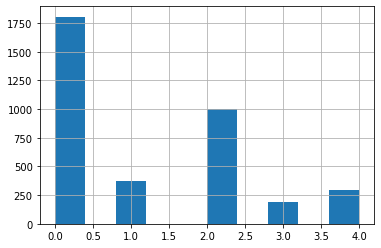

In [ ]:
train_df['diagnosis'].hist()
train_df['diagnosis'].value_counts()

In [ ]:
train_df['diagnosis'] = train_df['diagnosis'].astype('str')
train_df['id_code'] = train_df['id_code'].astype(str)+'.png'

In [ ]:
def crop_image1(img,tol=7):
    # img is image data
    # tol  is tolerance
        
    mask = img>tol
    return img[np.ix_(mask.any(1),mask.any(0))]

def crop_image_from_gray(img,tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
    #         print(img1.shape,img2.shape,img3.shape)
            img = np.stack([img1,img2,img3],axis=-1)
    #         print(img.shape)
        return img

In [ ]:
def load_ben_color(image, sigmaX=10):
#     image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = crop_image_from_gray(image)
    image = cv2.resize(image, (299, 299))
    image=cv2.addWeighted ( image,4, cv2.GaussianBlur( image , (0,0) , sigmaX) ,-4 ,128)
        
    return image

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

datagen=ImageDataGenerator(
    preprocessing_function=load_ben_color,
    rescale=1./255, 
    validation_split=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

batch_size = 16
image_size = 299



train_gen=datagen.flow_from_directory(

    directory="/content/drive/My Drive/BE Pro Materials/Diabetic Retinopa",
  
    
    batch_size=batch_size,
    shuffle=True,
    class_mode="categorical",
    target_size=(image_size,image_size),
    subset='training',
    classes=['train_split0','train_split1','train_split2','train_split3','train_split4'])

test_gen=datagen.flow_from_directory(
    
    directory="/content/drive/My Drive/BE Pro Materials/Diabetic Retinopa",
    batch_size=batch_size,
    shuffle=True,
    class_mode="categorical", 
    target_size=(image_size,image_size),
    subset='validation',
    classes=['train_split0','train_split1','train_split2','train_split3','train_split4'])

Found 2193 images belonging to 5 classes.
Found 546 images belonging to 5 classes.


In [ ]:
for i in y['id_code']:
  img=image.load_img(('/content/drive/My Drive/BE Pro Materials/Diabetic Retinopath/test_images/'+i+".png"),target_size=size)
  img=image.img_to_array(img)
  img=img.reshape(1,299,299,3)
  output=model.predict(img)
  pred1=np.append(pred1,(np.argmax(output[0])))

In [ ]:
from keras.applications import VGG16
#Load the VGG model
vgg_conv = VGG16(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

58892288/58889256 [==============================] - 6s 0us/step


In [ ]:
!pip install tensorflow==2.0

     |████████████████████████████████| 86.3MB 115kB/s 
     |████████████████████████████████| 450kB 44.1MB/s 
     |████████████████████████████████| 3.8MB 33.3MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=bc6ecd7f30894c089102a370be1f03d7fc90b9928ebd1ba93124ddecf3dac076
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
  Found existing installation: tensorflow-estimator 1.14.0
    Uninstalling tensorflow-estimator-1.14.0:
      Successfully uninstalled tensorflow-estimator-1.14.0
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully uninstalled gast-0.3.3
  Found existing installation: tensorboard 1.14.0
    Uninstalling tensorboard-1.14.0:
      Successfully uninstalled tensorboard-1.14.0
  Found existing installation: tensorflow 1.14.0
    Uninstalling tensorflow-1.14.0:
      Successfully uninstalled tensorflow-1.14.0


In [ ]:
y_train = train_df['diagnosis']
from keras.utils import np_utils
y_train = np_utils.to_categorical(y_train)
num_classes = y_train.shape[1]

In [ ]:
print(y_train)

[[0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]
 ...
 [0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]]


In [ ]:
# Freeze the layers except the last 4 layers
for layer in vgg_conv.layers[:-4]:
    layer.trainable = False
 
# Check the trainable status of the individual layers
for layer in vgg_conv.layers:
    print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7f1ffcfe1b70> False
<keras.layers.convolutional.Conv2D object at 0x7f1ffcff99b0> False
<keras.layers.convolutional.Conv2D object at 0x7f1ffcfe5048> False
<keras.layers.pooling.MaxPooling2D object at 0x7f1ffcff9a90> False
<keras.layers.convolutional.Conv2D object at 0x7f1ffcff9908> False
<keras.layers.convolutional.Conv2D object at 0x7f1ffcd8beb8> False
<keras.layers.pooling.MaxPooling2D object at 0x7f1ffcd17940> False
<keras.layers.convolutional.Conv2D object at 0x7f1ffcd17780> False
<keras.layers.convolutional.Conv2D object at 0x7f1ffcd1f470> False
<keras.layers.convolutional.Conv2D object at 0x7f1ffcd1ffd0> False
<keras.layers.pooling.MaxPooling2D object at 0x7f1ffcd26a90> False
<keras.layers.convolutional.Conv2D object at 0x7f1ffcd268d0> False
<keras.layers.convolutional.Conv2D object at 0x7f1ffcd2b5c0> False
<keras.layers.convolutional.Conv2D object at 0x7f1ffcd2beb8> False
<keras.layers.pooling.MaxPooling2D object at 0x7f1ffcd35be0>

In [ ]:
from keras import models
from keras import layers
from keras import optimizers
 
# Create the model
model = models.Sequential()
 
# Add the vgg convolutional base model
model.add(vgg_conv)
 
# Add new layers
model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(5, activation='softmax'))
 
# Show a summary of the model. Check the number of trainable parameters
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 9, 9, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 41472)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              42468352  
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 5125      
Total params: 57,188,165
Trainable params: 49,552,901
Non-trainable params: 7,635,264
_________________________________________________________________


In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K
 

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

In [ ]:
!pip install h5py

In [ ]:
from keras.models import Sequential
from keras.models import Model
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau, TensorBoard
from keras import optimizers, losses, activations, models
from keras.layers import Convolution2D, Dense, Input, Flatten, Dropout, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D, Concatenate
from keras import applications
from keras import optimizers

In [ ]:
EPOCHS = 30
BATCH_SIZE = 32
STEPS_PER_EPOCH = 35
VALIDATION_STEPS = 64

MODEL_FILE = 'model.hdf5'

history = model.fit_generator(
    train_gen,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_data=test_gen,
    validation_steps=VALIDATION_STEPS)
  
model.save(MODEL_FILE)

Epoch 1/30
35/35 [==============================] - 717s 20s/step - loss: 1.4186 - acc: 0.5786 - val_loss: 0.8760 - val_acc: 0.7176
Epoch 2/30
35/35 [==============================] - 349s 10s/step - loss: 0.9462 - acc: 0.6554 - val_loss: 0.8214 - val_acc: 0.7020
Epoch 3/30
35/35 [==============================] - 356s 10s/step - loss: 0.8528 - acc: 0.6964 - val_loss: 0.7304 - val_acc: 0.7490
Epoch 4/30
35/35 [==============================] - 347s 10s/step - loss: 0.7099 - acc: 0.7446 - val_loss: 0.7595 - val_acc: 0.7618
Epoch 5/30
35/35 [==============================] - 332s 9s/step - loss: 0.7319 - acc: 0.7534 - val_loss: 0.6889 - val_acc: 0.7412
Epoch 6/30
35/35 [==============================] - 230s 7s/step - loss: 0.6865 - acc: 0.7429 - val_loss: 0.6924 - val_acc: 0.7618
Epoch 7/30
35/35 [==============================] - 214s 6s/step - loss: 0.7470 - acc: 0.7179 - val_loss: 0.7912 - val_acc: 0.6775
Epoch 8/30
35/35 [==============================] - 211s 6s/step - loss: 0.7198

In [ ]:
EPOCHS = 30
BATCH_SIZE = 32
STEPS_PER_EPOCH = 35
VALIDATION_STEPS = 64

MODEL_FILE = 'model.hdf5'

history = model.fit_generator(
    train_gen,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_data=test_gen,
    validation_steps=VALIDATION_STEPS)
  
model.save(MODEL_FILE)

Epoch 1/30
35/35 [==============================] - 248s 7s/step - loss: 0.7942 - acc: 0.7232 - val_loss: 0.7241 - val_acc: 0.7333
Epoch 2/30
35/35 [==============================] - 218s 6s/step - loss: 0.7148 - acc: 0.7446 - val_loss: 0.7606 - val_acc: 0.7235
Epoch 3/30
35/35 [==============================] - 229s 7s/step - loss: 0.7713 - acc: 0.7177 - val_loss: 0.6989 - val_acc: 0.7303
Epoch 4/30
35/35 [==============================] - 223s 6s/step - loss: 0.7437 - acc: 0.7411 - val_loss: 0.7257 - val_acc: 0.7412
Epoch 5/30
35/35 [==============================] - 219s 6s/step - loss: 0.7829 - acc: 0.7232 - val_loss: 1.3713 - val_acc: 0.4471
Epoch 6/30
35/35 [==============================] - 239s 7s/step - loss: 0.7132 - acc: 0.7161 - val_loss: 0.7250 - val_acc: 0.7303
Epoch 7/30
35/35 [==============================] - 223s 6s/step - loss: 0.7209 - acc: 0.7679 - val_loss: 0.6649 - val_acc: 0.7441
Epoch 8/30
35/35 [==============================] - 223s 6s/step - loss: 0.6636 - a

In [ ]:
EPOCHS = 30
BATCH_SIZE = 32
STEPS_PER_EPOCH = 35
VALIDATION_STEPS = 64

MODEL_FILE = 'model.hdf5'

history = model.fit_generator(
    train_gen,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_data=test_gen,
    validation_steps=VALIDATION_STEPS)
  
model.save(MODEL_FILE)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/30
35/35 [==============================] - 1031s 29s/step - loss: 1.4439 - acc: 0.5232 - val_loss: 0.9479 - val_acc: 0.7235
Epoch 2/30
35/35 [==============================] - 474s 14s/step - loss: 0.9339 - acc: 0.6911 - val_loss: 0.8161 - val_acc: 0.7108
Epoch 3/30
35/35 [==============================] - 500s 14s/step - loss: 0.8191 - acc: 0.7000 - val_loss: 0.7593 - val_acc: 0.7146
Epoch 4/30
35/35 [==============================] - 496s 14s/step - loss: 0.8184 - acc: 0.6946 - val_loss: 0.6911 - val_acc: 0.7343
Epoch 5/30
35/35 [==============================] - 480s 14s/step - loss: 0.7159 - acc: 0.7391 - val_loss: 0.8585 - val_acc: 0.7137
Epoch 6/30
35/35 [==============================] - 267s 8s/step - loss: 0.7268 - acc: 0.7536 - val_loss: 0.7199 - val_acc: 0.7510
Epoch 7/30
35/35 [==============================] - 251s 7s/step - loss: 0.8107 - acc: 0.6984 - val_loss: 0.7139

In [ ]:
from keras.models import load_model
model=load_model('/content/drive/My Drive/BE Project/model.hdf5')

In [ ]:
pip install simplejson

     |████████████████████████████████| 92kB 10.8MB/s 
  Created wheel for simplejson: filename=simplejson-3.17.0-cp36-cp36m-linux_x86_64.whl size=114203 sha256=32bf6b2d680781cca978cc3dbd817640468ae4e164fcb39a71ee5ad90b56ddc2
  Stored in directory: /root/.cache/pip/wheels/86/c0/83/dcd0339abb2640544bb8e0938aab2d069cef55e5647ce6e097
Successfully built simplejson


In [ ]:
import simplejson as simplejson

In [ ]:
model_json = model.to_json()
with open("/content/drive/My Drive/BE Project/model.json", "w") as json_file:
    json_file.write(simplejson.dumps(simplejson.loads(model_json), indent=4))

In [ ]:
pip install tensorflowjs


     |████████████████████████████████| 61kB 8.2MB/s 
     |████████████████████████████████| 104.6MB 105kB/s 
     |████████████████████████████████| 256kB 68.5MB/s 
     |████████████████████████████████| 921kB 48.4MB/s 
     |████████████████████████████████| 3.9MB 42.7MB/s 
     |████████████████████████████████| 450kB 60.5MB/s 
  Created wheel for PyInquirer: filename=PyInquirer-1.0.3-cp36-none-any.whl size=32851 sha256=393fd4b16affcf3de0719996bd7a98e2074f81acd8b4b5174d2aae173fcd5b47
  Stored in directory: /root/.cache/pip/wheels/52/6c/b1/3e4b0e8daf42a92883c7641c0ea8ffb62e0490ebed2faa55ad
Successfully built PyInquirer
ERROR: tensorflow 1.15.0 has requirement tensorboard<1.16.0,>=1.15.0, but you'll have tensorboard 2.1.1 which is incompatible.
ERROR: tensorflow 1.15.0 has requirement tensorflow-estimator==1.15.1, but you'll have tensorflow-estimator 2.1.0 which is incompatible.
ERROR: tensorflow-federated 0.12.0 has requirement tensorflow~=2.1.0, but you'll have tensorflow 1.15.0 w

In [ ]:
from keras import backend as K

In [ ]:
def keras_to_tensorflow(keras_model, output_dir, model_name,out_prefix="output_", log_tensorboard=True):

    if os.path.exists(output_dir) == False:
        os.mkdir(output_dir)

    out_nodes = []

    for i in range(len(keras_model.outputs)):
        out_nodes.append(out_prefix + str(i + 1))
        tf.identity(keras_model.output[i], out_prefix + str(i + 1))

    sess = K.get_session()

    from tensorflow.python.framework import graph_util, graph_io

    init_graph = sess.graph.as_graph_def()

    main_graph = graph_util.convert_variables_to_constants(sess, init_graph, out_nodes)

    graph_io.write_graph(main_graph, output_dir, name=model_name, as_text=False)

    if log_tensorboard:
        from tensorflow.python.tools import import_pb_to_tensorboard

        import_pb_to_tensorboard.import_to_tensorboard(
            os.path.join(output_dir, model_name),
            output_dir)


In [ ]:
output_dir = '/content/drive/My Drive/BE Project'

In [ ]:
keras_to_tensorflow(model,output_dir=output_dir,model_name="retino.pb")

INFO:tensorflow:Froze 30 variables.
INFO:tensorflow:Converted 30 variables to const ops.
Model Imported. Visualize by running: tensorboard --logdir=/content/drive/My Drive/BE Project


In [ ]:
tensorboard --logdir=/content/drive/My Drive/BE Project

In [ ]:
import os
label=os.listdir('/content/drive/My Drive/BE Pro Materials/Diabetic Retinopath/test_images')
pred1=np.array([])
conf=np.array([])
true=np.array([])

In [ ]:

y=pd.read_csv('/content/drive/My Drive/BE Pro Materials/Diabetic Retinopath/test.csv')

In [ ]:
y.head()


,id_code
0,0005cfc8afb6
1,003f0afdcd15
2,006efc72b638
3,00836aaacf06
4,009245722fa4


In [ ]:
from keras.preprocessing import image

In [ ]:
size=(299,299)

In [ ]:
for i in y['id_code']:
  img=image.load_img(('/content/drive/My Drive/BE Pro Materials/Diabetic Retinopath/test_images/'+i+".png"),target_size=size)
  img=image.img_to_array(img)
  img=img.reshape(1,299,299,3)
  output=model.predict(img)
  pred1=np.append(pred1,(np.argmax(output[0])))

In [ ]:
pred = []
for j in pred1:
  pred.append(int(j))
print(pred)

[2, 2, 2, 2, 2, 2, 3, 0, 3, 0, 0, 4, 0, 0, 2, 0, 2, 2, 2, 0, 2, 2, 2, 2, 2, 0, 0, 2, 2, 0, 0, 2, 0, 0, 2, 1, 2, 2, 0, 3, 3, 2, 3, 2, 0, 3, 4, 3, 2, 2, 3, 2, 0, 0, 2, 0, 1, 0, 0, 2, 2, 2, 3, 2, 2, 3, 2, 4, 0, 3, 3, 2, 2, 0, 2, 2, 4, 3, 2, 0, 0, 2, 0, 0, 2, 2, 4, 4, 2, 0, 0, 2, 0, 4, 2, 2, 0, 0, 2, 2, 0, 0, 0, 2, 3, 2, 3, 4, 4, 0, 3, 3, 2, 0, 2, 2, 3, 0, 0, 2, 0, 0, 3, 2, 3, 4, 2, 2, 0, 0, 0, 2, 3, 0, 0, 2, 2, 2, 0, 4, 0, 0, 0, 4, 4, 2, 0, 0, 0, 2, 0, 2, 2, 2, 0, 0, 2, 2, 4, 0, 2, 3, 2, 2, 0, 3, 0, 4, 4, 2, 0, 2, 4, 3, 0, 2, 2, 4, 0, 0, 2, 2, 3, 2, 2, 2, 0, 0, 3, 0, 2, 4, 0, 2, 2, 2, 2, 0, 2, 3, 2, 3, 0, 2, 0, 2, 0, 2, 0, 2, 0, 3, 4, 2, 0, 2, 0, 2, 2, 0, 3, 3, 0, 2, 2, 2, 3, 2, 0, 2, 4, 2, 0, 0, 3, 0, 2, 4, 2, 2, 0, 4, 2, 0, 0, 3, 0, 3, 0, 2, 0, 0, 0, 2, 3, 0, 0, 0, 2, 4, 2, 3, 0, 0, 2, 2, 3, 0, 3, 0, 0, 0, 0, 0, 4, 2, 0, 4, 3, 3, 3, 3, 3, 2, 3, 0, 0, 0, 3, 2, 0, 4, 0, 0, 2, 0, 2, 2, 0, 2, 0, 2, 2, 3, 2, 3, 2, 2, 0, 0, 2, 2, 2, 0, 2, 2, 0, 4, 0, 0, 0, 0, 0, 0, 2, 4, 0, 2, 2, 2, 2, 0, 0, 

In [ ]:
x = pd.DataFrame({'id_code':y['id_code'],'diagnosis': pred })

In [ ]:

x.head()

In [ ]:
img=image.load_img(("/content/drive/My Drive/BE Pro Materials/Diabetic Retinopath/test_images/0005cfc8afb6.png"),target_size=size)
img=image.img_to_array(img)
# img=load_ben_color(img)
img=img.reshape(1,299,299,3)

output=model.predict_proba(img)
outpu=model.predict(img)
print(outpu)
print(np.argmax(outpu))
if output(output[np.argmax(outpu)]<1.0):
  print("Enter Valid")
else:
  print(np.argmax(outpu))


In [ ]:
pip install keras==2.3.0

     |████████████████████████████████| 378kB 7.6MB/s 
  Found existing installation: Keras 2.2.5
    Uninstalling Keras-2.2.5:
      Successfully uninstalled Keras-2.2.5


In [ ]:
pip install keras==2.3.0

     |████████████████████████████████| 378kB 34.1MB/s 
  Found existing installation: Keras 2.2.5
    Uninstalling Keras-2.2.5:
      Successfully uninstalled Keras-2.2.5


In [ ]:
pip install tensorflow==2.0

     |████████████████████████████████| 86.3MB 36kB/s 
     |████████████████████████████████| 450kB 39.4MB/s 
     |████████████████████████████████| 3.8MB 34.7MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=9bf7762223977c46e93ecd8b7af2bda8244e1620381981e5a637dad959f1b16e
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
  Found existing installation: tensorflow-estimator 2.2.0rc0
    Uninstalling tensorflow-estimator-2.2.0rc0:
      Successfully uninstalled tensorflow-estimator-2.2.0rc0
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully uninstalled gast-0.3.3
  Found existing installation: tensorboard 2.2.0
    Uninstalling tensorboard-2.2.0:
      Successfully uninstalled tensorboard-2.2.0
  Found existing installation: tensorflow 2.2.0rc2
    Uninstalling tensorflow-2.2.0rc2:
      Successfully uninstalled tensorflow-2.2.0rc2

In [ ]:
from keras.models import load_model
model=load_model('/content/drive/My Drive/BE Project/model.hdf5')

KeyboardInterrupt: ignored

In [ ]:
import cv2

In [ ]:
path=f"/content/drive/My Drive/BE Pro Materials/Diabetic Retinopath/test_images/0005cfc8afb6.png"
imd = cv2.imread(path)
plt.imshow(imd)

In [ ]:
img=image.load_img(("/content/drive/My Drive/Traditional day/IMG_0949.JPG"),target_size=size)
img=image.img_to_array(img)
img=img.reshape(1,299,299,3)
output=model.predict(img)

print(np.argmax(output))

0


In [ ]:
path=f"/content/drive/My Drive/Traditional day/IMG_0949.JPG"
imd = cv2.imread(path)
plt.imshow(imd,)

In [ ]:
img=image.load_img(("/content/drive/My Drive/Diabetic Retinopath/test_images/01499815e469.png"),target_size=size)
img=image.img_to_array(img)
img=img.reshape(1,299,299,3)
output=model.predict(img)

print(np.argmax(output))

4


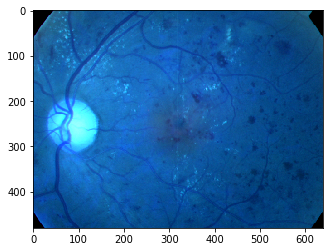

In [ ]:
path=f"/content/drive/My Drive/Diabetic Retinopath/test_images/01499815e469.png"
imd = cv2.imread(path)
plt.imshow(imd,)

The below image is of 3


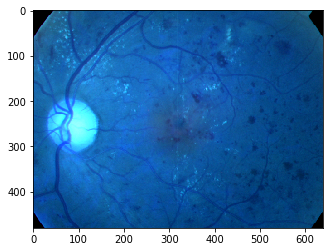

In [ ]:
img=image.load_img(("/content/drive/My Drive/Diabetic Retinopath/test_images/01499815e469.png"),target_size=size)
img=image.img_to_array(img)
img=img.reshape(1,299,299,3)
output=model.predict(img)
path=f"/content/drive/My Drive/Diabetic Retinopath/test_images/01499815e469.png"
imd = cv2.imread(path)
plt.imshow(imd)
print("The below image is of",np.argmax(output))

The below image is of level 0


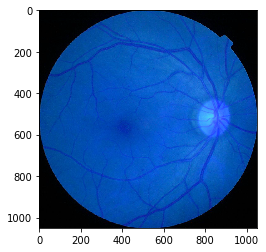

In [ ]:
img=image.load_img(("/content/drive/My Drive/Diabetic Retinopath/test_images/0111b949947e.png"),target_size=size)
img=image.img_to_array(img)
img=img.reshape(1,299,299,3)
output=model.predict(img)
path=f"/content/drive/My Drive/Diabetic Retinopath/test_images/0111b949947e.png"
imd = cv2.imread(path)
plt.imshow(imd,)
print("The below image is of level",np.argmax(output))

The below image is of level  2


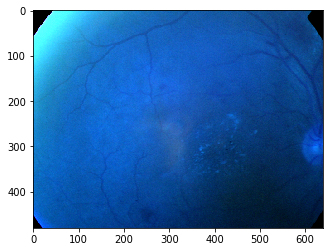

In [ ]:
img=image.load_img(("/content/drive/My Drive/Diabetic Retinopath/test_images/0005cfc8afb6.png"),target_size=size)
img=image.img_to_array(img)
img=img.reshape(1,299,299,3)
output=model.predict(img)
path=f"/content/drive/My Drive/Diabetic Retinopath/test_images/0005cfc8afb6.png"
imd = cv2.imread(path)
plt.imshow(imd,)
print("The below image is of level ",np.argmax(output))

In [ ]:
EPOCHS = 10
BATCH_SIZE = 32
STEPS_PER_EPOCH = 10
VALIDATION_STEPS = 64

MODEL_FILE = 'model.hdf5'

history = model.fit_generator(
    train_gen,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_data=test_gen,
    validation_steps=VALIDATION_STEPS)
  
model.save(MODEL_FILE)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/10
10/10 [==============================] - 641s 64s/step - loss: 3.9131 - acc: 0.3500 - val_loss: 1.1707 - val_acc: 0.4735
Epoch 2/10
10/10 [==============================] - 161s 16s/step - loss: 1.3497 - acc: 0.4875 - val_loss: 0.9997 - val_acc: 0.6500
Epoch 3/10
10/10 [==============================] - 159s 16s/step - loss: 1.0764 - acc: 0.6250 - val_loss: 0.8850 - val_acc: 0.7028
Epoch 4/10
10/10 [==============================] - 160s 16s/step - loss: 0.7077 - acc: 0.8172 - val_loss: 0.8895 - val_acc: 0.6775
Epoch 5/10
10/10 [==============================] - 165s 16s/step - loss: 0.9730 - acc: 0.6937 - val_loss: 0.8233 - val_acc: 0.7157
Epoch 6/10
10/10 [==============================] - 166s 17s/step - loss: 0.9401 - acc: 0.6500 - val_loss: 0.7950 - val_acc: 0.7234
Epoch 7/10
10/10 [==============================] - 159s 16s/step - loss: 0.8064 - acc: 0.6688 - val_loss: 0.986

In [ ]:
EPOCHS = 30
BATCH_SIZE = 32
STEPS_PER_EPOCH = 35
VALIDATION_STEPS = 64

MODEL_FILE = '/content/drive/My Drive/Diabetic Retinopath/model.hdf5'

history = model.fit_generator(
    train_gen,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_data=test_gen,
    validation_steps=VALIDATION_STEPS)
  
model.save(MODEL_FILE)

Epoch 1/30
35/35 [==============================] - 709s 20s/step - loss: 0.5873 - acc: 0.8089 - val_loss: 0.6616 - val_acc: 0.7529
Epoch 2/30
35/35 [==============================] - 360s 10s/step - loss: 0.6098 - acc: 0.7714 - val_loss: 0.5590 - val_acc: 0.7941
Epoch 3/30
35/35 [==============================] - 351s 10s/step - loss: 0.6181 - acc: 0.7877 - val_loss: 0.6629 - val_acc: 0.7618
Epoch 4/30
35/35 [==============================] - 365s 10s/step - loss: 0.6097 - acc: 0.7661 - val_loss: 0.5807 - val_acc: 0.7931
Epoch 5/30
35/35 [==============================] - 339s 10s/step - loss: 0.5959 - acc: 0.7875 - val_loss: 0.5688 - val_acc: 0.7853
Epoch 6/30
35/35 [==============================] - 240s 7s/step - loss: 0.6036 - acc: 0.7927 - val_loss: 0.5881 - val_acc: 0.7913
Epoch 7/30
35/35 [==============================] - 234s 7s/step - loss: 0.5686 - acc: 0.7839 - val_loss: 0.6231 - val_acc: 0.7784
Epoch 8/30
35/35 [==============================] - 248s 7s/step - loss: 0.613

The below image is of level  2


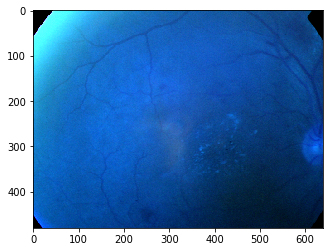

In [ ]:
img=image.load_img(("/content/drive/My Drive/Diabetic Retinopath/test_images/0005cfc8afb6.png"),target_size=size)
img=image.img_to_array(img)
img=img.reshape(1,299,299,3)
output=model.predict(img)
path=f"/content/drive/My Drive/Diabetic Retinopath/test_images/0005cfc8afb6.png"
imd = cv2.imread(path)
plt.imshow(imd,)
print("The below image is of level ",np.argmax(output))

The below image is of level 0


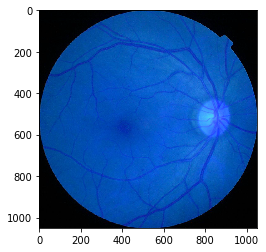

In [ ]:
img=image.load_img(("/content/drive/My Drive/Diabetic Retinopath/test_images/0111b949947e.png"),target_size=size)
img=image.img_to_array(img)
img=img.reshape(1,299,299,3)
output=model.predict(img)
path=f"/content/drive/My Drive/Diabetic Retinopath/test_images/0111b949947e.png"
imd = cv2.imread(path)
plt.imshow(imd,)
print("The below image is of level",np.argmax(output))

The below image is of 3


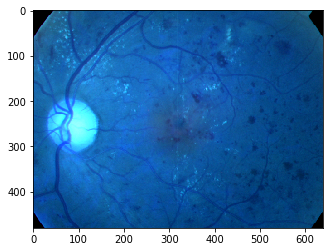

In [ ]:
img=image.load_img(("/content/drive/My Drive/Diabetic Retinopath/test_images/01499815e469.png"),target_size=size)
img=image.img_to_array(img)
img=load_ben_color(img)
img=img.reshape(1,299,299,3)
output=model.predict(img)
path=f"/content/drive/My Drive/Diabetic Retinopath/test_images/01499815e469.png"
imd = cv2.imread(path)
plt.imshow(imd)
print("The below image is of",np.argmax(output))

In [ ]:
EPOCHS = 30
BATCH_SIZE = 32
STEPS_PER_EPOCH = 35
VALIDATION_STEPS = 64

MODEL_FILE = '/content/drive/My Drive/Diabetic Retinopath/model.hdf5'

history = model.fit_generator(
    train_gen,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_data=test_gen,
    validation_steps=VALIDATION_STEPS)
  
model.save(MODEL_FILE)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/30
35/35 [==============================] - 785s 22s/step - loss: 1.2229 - acc: 0.6000 - val_loss: 1.0827 - val_acc: 0.5706
Epoch 2/30
35/35 [==============================] - 396s 11s/step - loss: 0.8862 - acc: 0.7089 - val_loss: 0.7447 - val_acc: 0.7275
Epoch 3/30
35/35 [==============================] - 368s 11s/step - loss: 0.8491 - acc: 0.7107 - val_loss: 0.7818 - val_acc: 0.7293
Epoch 4/30
35/35 [==============================] - 382s 11s/step - loss: 0.7842 - acc: 0.7373 - val_loss: 0.6934 - val_acc: 0.7363
Epoch 5/30
35/35 [==============================] - 375s 11s/step - loss: 0.7898 - acc: 0.7036 - val_loss: 0.7171 - val_acc: 0.7373
Epoch 6/30
35/35 [==============================] - 257s 7s/step - loss: 0.7117 - acc: 0.7482 - val_loss: 0.6805 - val_acc: 0.7333
Epoch 7/30
35/35 [==============================] - 249s 7s/step - loss: 0.7023 - acc: 0.7570 - val_loss: 1.0430 

The below image is of 3


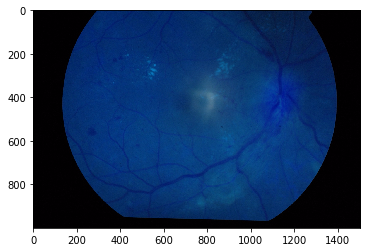

In [ ]:
img=image.load_img(("/content/drive/My Drive/Diabetic/data/train/train_split3/fe0fc67c7980.png"),target_size=size)
img=image.img_to_array(img)
img=img.reshape(1,299,299,3)
output=model.predict(img)
path=f"/content/drive/My Drive/Diabetic/data/train/train_split3/fe0fc67c7980.png"
imd = cv2.imread(path)
plt.imshow(imd)
print("The below image is of",np.argmax(output))

In [ ]:
img=image.load_img(("/content/drive/My Drive/Diabetic/data/train/train_split3/fe0fc67c7980.png"),target_size=size)
img=image.img_to_array(img)

img=img.reshape(1,299,299,3)
output=model.predict(img)
path=f"/content/drive/My Drive/Diabetic/data/train/train_split3/fe0fc67c7980.png"
imd = cv2.imread(path)
plt.imshow(imd)
print("The below image is of",np.argmax(output))

The below image is of 3


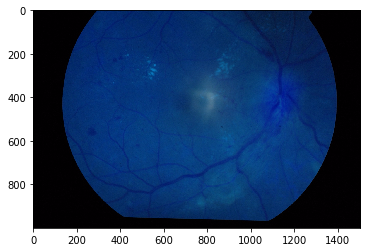

In [ ]:
img=image.load_img(("/content/drive/My Drive/Diabetic/data/train/train_split3/fe0fc67c7980.png"),target_size=size)
img=image.img_to_array(img)
img=load_ben_color(img)
img=img.reshape(1,299,299,3)
output=model.predict(img)
path=f"/content/drive/My Drive/Diabetic/data/train/train_split3/fe0fc67c7980.png"
imd = cv2.imread(path)
plt.imshow(imd)
print("The below image is of",np.argmax(output))

The below image is of 4


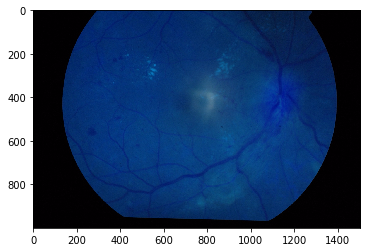

In [ ]:
img=image.load_img(("/content/drive/My Drive/Diabetic/data/train/train_split3/fe0fc67c7980.png"),target_size=size)
img=image.img_to_array(img)
img=load_ben_color(img)
img=img.reshape(1,299,299,3)
output=model.predict(img)
path=f"/content/drive/My Drive/Diabetic/data/train/train_split3/fe0fc67c7980.png"
imd = cv2.imread(path)
plt.imshow(imd)
print("The below image is of",np.argmax(output))

The below image is of 0


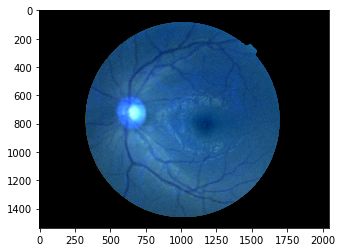

In [ ]:
img=image.load_img(("/content/drive/My Drive/Diabetic/data/val/train_split0/6b30767595d8.png"),target_size=size)
img=image.img_to_array(img)
img=img.reshape(1,299,299,3)
output=model.predict(img)
path=f"/content/drive/My Drive/Diabetic/data/val/train_split0/6b30767595d8.png"
imd = cv2.imread(path)
plt.imshow(imd)
print("The below image is of",np.argmax(output))

The below image is of 0


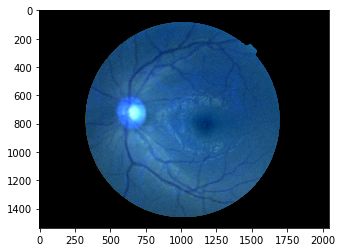

In [ ]:
img=image.load_img(("/content/drive/My Drive/Diabetic/data/val/train_split0/6b30767595d8.png"),target_size=size)
img=image.img_to_array(img)
img=load_ben_color(img)
img=img.reshape(1,299,299,3)
output=model.predict(img)
path=f"/content/drive/My Drive/Diabetic/data/val/train_split0/6b30767595d8.png"
imd = cv2.imread(path)
plt.imshow(imd)
print("The below image is of",np.argmax(output))

The below image is of 2


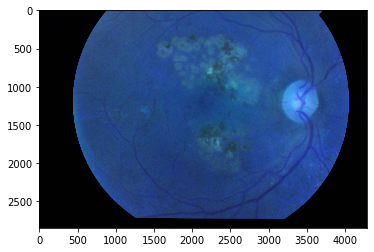

In [ ]:
img=image.load_img(("/content/drive/My Drive/Diabetic/data/test/train_split1/e9286ddf6ffe.png"),target_size=size)
img=image.img_to_array(img)
img=img.reshape(1,299,299,3)
output=model.predict(img)
path=f"/content/drive/My Drive/Diabetic/data/test/train_split1/e9286ddf6ffe.png"
imd = cv2.imread(path)
plt.imshow(imd)
print("The below image is of",np.argmax(output))

The below image is of 3


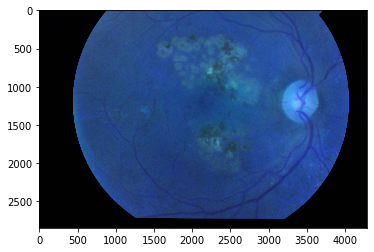

In [ ]:
img=image.load_img(("/content/drive/My Drive/Diabetic/data/test/train_split1/e9286ddf6ffe.png"),target_size=size)
img=image.img_to_array(img)
img=load_ben_color(img)
img=img.reshape(1,299,299,3)
output=model.predict(img)
path=f"/content/drive/My Drive/Diabetic/data/test/train_split1/e9286ddf6ffe.png"
imd = cv2.imread(path)
plt.imshow(imd)
print("The below image is of",np.argmax(output))

The below image is of 0


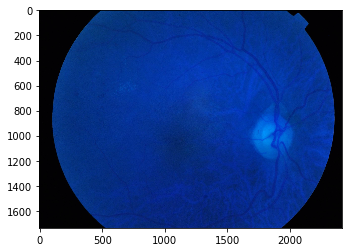

In [ ]:
img=image.load_img(("/content/drive/My Drive/Diabetic/data/test/train_split1/fca931da5c5e.png"),target_size=size)
img=image.img_to_array(img)
img=img.reshape(1,299,299,3)
output=model.predict(img)
path=f"/content/drive/My Drive/Diabetic/data/test/train_split1/fca931da5c5e.png"
imd = cv2.imread(path)
plt.imshow(imd)
print("The below image is of",np.argmax(output))

The below image is of 2


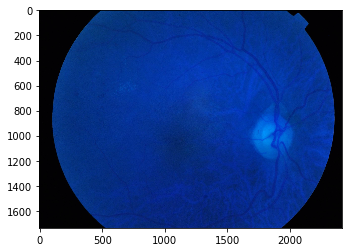

In [ ]:
img=image.load_img(("/content/drive/My Drive/Diabetic/data/test/train_split1/fca931da5c5e.png"),target_size=size)

img=image.img_to_array(img)
img=load_ben_color(img)
img=img.reshape(1,299,299,3)
output=model.predict(img)
path=f"/content/drive/My Drive/Diabetic/data/test/train_split1/fca931da5c5e.png"
imd = cv2.imread(path)
plt.imshow(imd)
print("The below image is of",np.argmax(output))

In [ ]:
EPOCHS = 30
BATCH_SIZE = 32
STEPS_PER_EPOCH = 35
VALIDATION_STEPS = 64

MODEL_FILE = '/content/drive/My Drive/Diabetic/model.hdf5'

history = model.fit_generator(
    train_gen,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_data=test_gen,
    validation_steps=VALIDATION_STEPS)
  
model.save(MODEL_FILE)

In [ ]:
pip install tensorflowjs


     |████████████████████████████████| 61kB 9.7MB/s 
     |████████████████████████████████| 104.6MB 1.2MB/s 
     |████████████████████████████████| 450kB 55.0MB/s 
     |████████████████████████████████| 3.9MB 64.0MB/s 
     |████████████████████████████████| 256kB 78.5MB/s 
     |████████████████████████████████| 921kB 76.4MB/s 
  Created wheel for PyInquirer: filename=PyInquirer-1.0.3-cp36-none-any.whl size=32851 sha256=013b0bf6907d3a4b7c6540bafdeab3df71326ac7b451feca63af4e70c0d8d181
  Stored in directory: /root/.cache/pip/wheels/52/6c/b1/3e4b0e8daf42a92883c7641c0ea8ffb62e0490ebed2faa55ad
Successfully built PyInquirer
ERROR: tensorflow 1.15.0 has requirement tensorboard<1.16.0,>=1.15.0, but you'll have tensorboard 2.1.1 which is incompatible.
ERROR: tensorflow 1.15.0 has requirement tensorflow-estimator==1.15.1, but you'll have tensorflow-estimator 2.1.0 which is incompatible.
ERROR: tensorflow-federated 0.12.0 has requirement tensorflow~=2.1.0, but you'll have tensorflow 1.15.0 w

In [ ]:
pip install -U ipython


     |████████████████████████████████| 788kB 38.8MB/s 
     |████████████████████████████████| 358kB 49.4MB/s 
ERROR: pyinquirer 1.0.3 has requirement prompt-toolkit==1.0.14, but you'll have prompt-toolkit 3.0.4 which is incompatible.
ERROR: jupyter-console 5.2.0 has requirement prompt-toolkit<2.0.0,>=1.0.0, but you'll have prompt-toolkit 3.0.4 which is incompatible.
ERROR: google-colab 1.0.0 has requirement ipython~=5.5.0, but you'll have ipython 7.13.0 which is incompatible.
  Found existing installation: prompt-toolkit 1.0.14
    Uninstalling prompt-toolkit-1.0.14:
      Successfully uninstalled prompt-toolkit-1.0.14
  Found existing installation: ipython 5.5.0
    Uninstalling ipython-5.5.0:
      Successfully uninstalled ipython-5.5.0


In [ ]:
tensorflowjs_converter --input_format keras content/drive/My Drive/BE Project/model.hdf5 content/drive/MyDrive/BE Project/

SyntaxError: ignored

In [ ]:
tensorflowjs_converter \
    --input_format=keras \
  /content/drive/My Drive/BE Project/model.hdf5 \
  /content/drive/MyDrive/BE Project/my_tfjs_model

In [ ]:
pip install keras==2.3.0

     |████████████████████████████████| 378kB 5.6MB/s 
  Found existing installation: Keras 2.2.5
    Uninstalling Keras-2.2.5:
      Successfully uninstalled Keras-2.2.5


In [ ]:
pip install tensorflow==2.0

     |████████████████████████████████| 86.3MB 35kB/s 
     |████████████████████████████████| 450kB 42.0MB/s 
     |████████████████████████████████| 3.8MB 40.5MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=d22e62ca7c10a0cb9844fb79b9e2fadea316cc2ee7e7c19ecdd4a3279b712c6c
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
  Found existing installation: tensorflow-estimator 2.2.0rc0
    Uninstalling tensorflow-estimator-2.2.0rc0:
      Successfully uninstalled tensorflow-estimator-2.2.0rc0
  Found existing installation: tensorboard 2.2.0
    Uninstalling tensorboard-2.2.0:
      Successfully uninstalled tensorboard-2.2.0
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully uninstalled gast-0.3.3
  Found existing installation: tensorflow 2.2.0rc2
    Uninstalling tensorflow-2.2.0rc2:
      Successfully uninstalled tensorflow-2.2.0rc2

In [ ]:
from keras.models import load_model
model=load_model('/content/drive/My Drive/BE Pro Materials/model.hdf5')

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
test_dir="/content/drive/My Drive/BE Pro Materials/Diabetic Retinopath/test_images"

In [ ]:
datagen=ImageDataGenerator(
  preprocessing_function=load_ben_color,
    rescale=1./255, 
    validation_split=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

batch_size = 16
image_size = 299





# test_gene=datagen.flow_from_dataframe(
#     test_df,
#     x_col = 'id_code',
#     y_col = None,
#     directory="/content/drive/My Drive/BE Pro Materials/Diabetic Retinopath/test_images",
#     batch_size=batch_size,
#     shuffle=True,
#     class_mode= None, 
#     target_size=(image_size,image_size),
#     subset='training')

In [ ]:
FLOW1_model = load_model('/content/drive/My Drive/BE Project/model.hdf5')

#Confusion Matrix and Classification Report

print(test_gene.samples )
print(test_gene.batch_size)
Y_pred = FLOW1_model.predict_generator(test_gen, test_gene.samples // test_gene.batch_size)
y_pred = np.argmax(Y_pred, axis=1)
print(y_pred)

In [ ]:
test_generator = datagen.flow_from_directory(
    directory="/content/drive/My Drive/BE Pro Materials/Diabetic Retinopa",
    target_size=(299, 299),
    color_mode="rgb",
    batch_size=1,
    shuffle = False,
    class_mode='categorical',
    classes=['train_split0','train_split1','train_split2','train_split3','train_split4']
   
)

filenames = test_generator.filenames
nb_samples = len(filenames)

Found 2739 images belonging to 5 classes.


In [ ]:
test_generator = datagen.flow_from_directory(
    directory="/content/drive/My Drive/BE Pro Materials/Diabetic Retinopa",
    target_size=(299, 299),
    color_mode="rgb",
    batch_size=1,
    shuffle = False,
    class_mode='categorical',
    classes=['train_split0','train_split1','train_split2','train_split3','train_split4']
   
)

filenames = test_generator.filenames
nb_samples = len(filenames)


Found 283 images belonging to 5 classes.


In [ ]:

filenames = test_gen.filenames
nb_samples = len(filenames)

In [ ]:
print(nb_samples)

2739


In [ ]:
filenames = test_generator.filenames
nb_samples = len(filenames)
print(nb_samples)

283


In [ ]:
filenames = test_generator.filenames
nb_samples = len(filenames)
print(nb_samples)

2739


In [ ]:
predict = model.predict_generator(test_generator,nb_samples)
print(predict)
print(len(predict))

[[9.97072458e-01 9.81960678e-04 1.55136141e-03 6.46774515e-06
  3.87856591e-04]
 [8.99008632e-01 1.08892350e-02 7.15898871e-02 3.30725196e-03
  1.52049605e-02]
 [9.42961693e-01 9.08028148e-03 3.95469666e-02 7.19967997e-04
  7.69113237e-03]
 ...
 [7.86816794e-03 3.19764227e-01 3.76597106e-01 5.00452146e-02
  2.45725244e-01]
 [6.74447801e-05 2.26918887e-02 4.68472958e-01 3.17427456e-01
  1.91340223e-01]
 [8.65619816e-03 3.30686495e-02 6.35402679e-01 9.92523581e-02
  2.23620117e-01]]
283


In [ ]:
predict = model.predict_generator(test_gen,nb_samples)
print(predict)
print(len(predict))

KeyboardInterrupt: ignored

In [ ]:
predict = model.predict_generator(test_generator,nb_samples)
print(predict)
print(len(predict))

[[9.5618010e-01 8.7760165e-03 2.4974594e-02 1.3052486e-03 8.7641273e-03]
 [2.0707329e-01 4.0772628e-02 6.8722892e-01 1.0632555e-02 5.4292716e-02]
 [7.1856338e-01 4.6775192e-02 2.1278977e-01 1.2206102e-03 2.0651054e-02]
 ...
 [4.5640773e-01 2.6806697e-01 1.4032130e-01 8.4620155e-03 1.2674196e-01]
 [3.3590168e-05 1.2617871e-02 3.5480279e-01 4.1624942e-01 2.1629634e-01]
 [3.0050930e-03 2.1082504e-02 6.2693793e-01 1.2523209e-01 2.2374240e-01]]
2739


In [ ]:
y_pred = np.argmax(predict, axis=1)

In [ ]:
y_pred = np.argmax(predict, axis=1)

In [ ]:
y_pred = np.argmax(predict, axis=1)

In [ ]:
print(y_pred)

[0 2 0 ... 0 3 2]


In [ ]:
print(y_pred)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2
 0 0 0 2 0 0 0 0 0 2 0 0 4 2 0 0 0 1 2 2 2 0 0 0 4 0 0 0 1 0 0 0 0 0 1 0 2
 0 0 2 0 2 2 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 1 0 2 2 0 0 0 0 0 2 0 2 2 2
 0 0 0 0 0 0 0 0 2 2 0 4 0 0 2 2 0 2 2 0 2 2 0 0 2 2 2 0 4 0 0 1 0 2 0 0 2
 2 2 4 0 2 2 0 0 0 2 2 2 2 0 2 2 0 3 2 2 4 2 0 2 2 2 2 2 0 2 2 0 2 0 2 2 4
 2 2 2 2 0 0 2 2 0 2 2 2 2 2 2 2 2 2 1 2 2 2 3 2 4 0 2 2 2 2 2 4 0 4 2 0 2
 2 2 2 0 2 2 2 4 0 0 2 2 2 2 0 0 2 1 2 0 2 2 0 0 0 2 2 1 2 0 2 2 2 0 0 2 2
 0 2 0 0 2 2 2 1 0 0 2 2 0 2 0 0 2 2 0 1 0 2 2 2]


In [ ]:
print(len(y_pred))

2739


In [ ]:
print(len(y_pred))

283


In [ ]:
print(len(y_pred))

2739


In [ ]:
print(confusion_matrix(test_generator.classes, y_pred))

[[38  0  1  0  0]
 [57  4 17  0  2]
 [17  1 19  0  3]
 [ 9  1 35  1  2]
 [25  4 42  1  4]]


In [ ]:
print(confusion_matrix(test_generator.classes, y_pred))

[[779   2 100   0   1]
 [234  19 108   0   9]
 [296  35 642   3  23]
 [ 25   4 145  13   6]
 [ 81  10 175   6  23]]


In [ ]:
print('Classification Report')
target_names = ['0', '1', '2','3','4']
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

Classification Report
              precision    recall  f1-score   support

           0       1.00      0.11      0.20      1937
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0

    accuracy                           0.11      1937
   macro avg       0.20      0.02      0.04      1937
weighted avg       1.00      0.11      0.20      1937



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
print('Classification Report')
target_names = ['0', '1', '2','3','4']
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

Classification Report
              precision    recall  f1-score   support

           0       0.26      0.97      0.41        39
           1       0.40      0.05      0.09        80
           2       0.17      0.47      0.25        40
           3       0.50      0.02      0.04        48
           4       0.36      0.05      0.09        76

    accuracy                           0.23       283
   macro avg       0.34      0.31      0.18       283
weighted avg       0.35      0.23      0.15       283



In [ ]:
print('Classification Report')
target_names = ['0', '1', '2','3','4']
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

Classification Report
              precision    recall  f1-score   support

           0       0.55      0.88      0.68       882
           1       0.27      0.05      0.09       370
           2       0.55      0.64      0.59       999
           3       0.59      0.07      0.12       193
           4       0.37      0.08      0.13       295

    accuracy                           0.54      2739
   macro avg       0.47      0.34      0.32      2739
weighted avg       0.50      0.54      0.47      2739



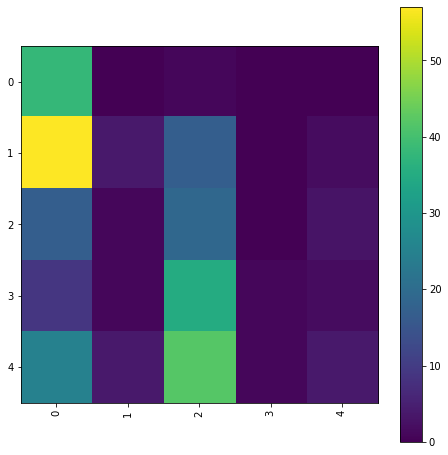

In [ ]:
plt.figure(figsize=(8,8))
cnf_matrix = confusion_matrix(test_generator.classes, y_pred)

plt.imshow(cnf_matrix, interpolation='nearest')
plt.colorbar()
tick_marks = np.arange(len(target_names))
_ = plt.xticks(tick_marks, target_names, rotation=90)
_ = plt.yticks(tick_marks, target_names)
plt.show();

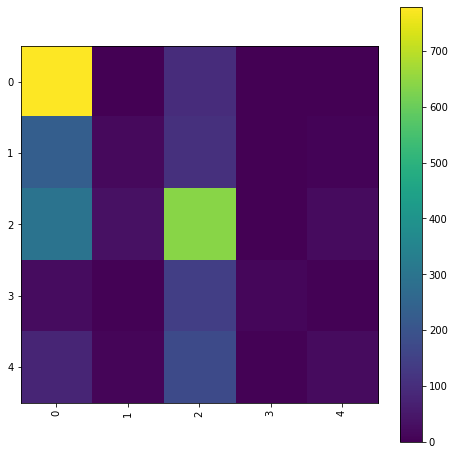

In [ ]:
plt.figure(figsize=(8,8))
cnf_matrix = confusion_matrix(test_generator.classes, y_pred)

plt.imshow(cnf_matrix, interpolation='nearest')
plt.colorbar()
tick_marks = np.arange(len(target_names))
_ = plt.xticks(tick_marks, target_names, rotation=90)
_ = plt.yticks(tick_marks, target_names)
plt.show();

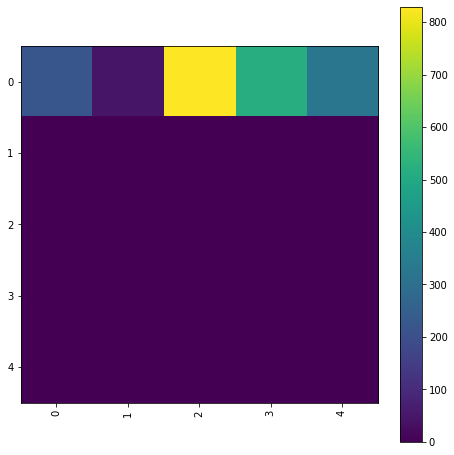

In [ ]:
plt.figure(figsize=(8,8))
cnf_matrix = confusion_matrix(test_generator.classes, y_pred)

plt.imshow(cnf_matrix, interpolation='nearest')
plt.colorbar()
tick_marks = np.arange(len(target_names))
_ = plt.xticks(tick_marks, target_names, rotation=90)
_ = plt.yticks(tick_marks, target_names)
plt.show();

In [ ]:
import seaborn as sns

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from sklearn import manifold
from sklearn import model_selection, linear_model

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

In [ ]:

labels = [0,1,2,3,4]
cm = confusion_matrix(test_generator.classes, y_pred, labels=labels)
print(cm)

[[779   2 100   0   1]
 [234  19 108   0   9]
 [296  35 642   3  23]
 [ 25   4 145  13   6]
 [ 81  10 175   6  23]]


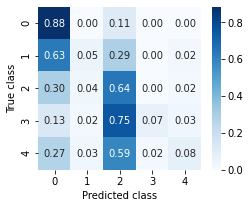

In [ ]:
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(4, 3))
sns.heatmap(cm_norm, square=True, annot=True, fmt='0.2f',
            annot_kws={'fontsize':10}, cmap='Blues', 
            xticklabels=labels, yticklabels=labels);
plt.ylabel('True class');
plt.xlabel('Predicted class');

In [ ]:
print(test_gen)

In [ ]:
print(len(test_gen))

46


In [ ]:
print(len(Y_pred))

720


In [ ]:
print(len(y_pred))

720


In [ ]:
print(len(test_gen.classes))

732


In [ ]:
FLOW1_model = load_model('/content/drive/My Drive/BE Project/model.hdf5')

#Confusion Matrix and Classification Report
Y_pred = FLOW1_model.predict_generator(test_gen, test_gen.samples // test_gen.batch_size)
y_pred = np.argmax(Y_pred, axis=1)
print(y_pred)
print('Confusion Matrix')
print(confusion_matrix(test_gen.classes, y_pred))
print('Classification Report')
target_names = ['0', '1', '2','3','4']
print(classification_report(test_gen.classes, y_pred, target_names=target_names))


#Evaluating using Keras model_evaluate:
x, y = zip(*(test_gen[i] for i in range(len(test_gen))))
x_test, y_test = np.vstack(x), np.vstack(y)
loss, acc = FLOW1_model.evaluate(x_test, y_test, batch_size=64)

print("Accuracy: " ,acc)
print("Loss: ", loss)

In [ ]:
generator = datagen.flow_from_directory(
        directory='/content/drive/My Drive/BE Pro Materials/Diabetic Retinopath/test_images',
        target_size=(150, 150),
        batch_size=16,
        class_mode=None,  # only data, no labels
        shuffle=False)  # keep data in same order as labels

probabilities = model.predict_generator(generator,generator.samples // generator.batch_size )

Found 0 images belonging to 0 classes.


In [ ]:
from sklearn.metrics import confusion_matrix

y_true = np.array([0] * 1000 + [1] * 1000)
y_pred = np.argmax(probabilities, axis=1)

confusion_matrix(y_true, y_pred)

In [ ]:
for i in y['id_code']:
  img=image.load_img(('/content/drive/My Drive/BE Pro Materials/Diabetic Retinopath/test_images/'+i+".png"),target_size=size)
  img=image.img_to_array(img)
  img=img.reshape(1,299,299,3)
  output=model.predict(img)
  pred1=np.append(pred1,(np.argmax(output[0])))

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import keras
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
from keras.models import load_model


In [ ]:
train_gene=datagen.flow_from_directory(

    directory="/content/drive/My Drive/BE Pro Materials/Diabetic Retinopa",
  
    
    batch_size=9,
    shuffle=True,
    class_mode="categorical",
    target_size=(299,299),
    subset='training',
    classes=['train_split0','train_split1','train_split2','train_split3','train_split4'])

test_gene=datagen.flow_from_directory(
    
    directory="/content/drive/My Drive/BE Pro Materials/Diabetic Retinopa",
    batch_size=9,
    shuffle=True,
    class_mode="categorical", 
    target_size=(299,299),
    subset='validation',
    classes=['train_split0','train_split1','train_split2','train_split3','train_split4'])

Found 2193 images belonging to 5 classes.
Found 546 images belonging to 5 classes.


In [ ]:

image_size = 299

test_batchsize = 9

In [ ]:
test_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
train_gen=test_datagen.flow_from_directory(
        directory="/content/drive/My Drive/BE Pro Materials/Diabetic Retinopa",
        target_size=(image_size, image_size),
        batch_size=test_batchsize,
        class_mode='categorical',
        shuffle=True,
    subset='training')


test_generator = test_datagen.flow_from_directory(
        directory="/content/drive/My Drive/BE Pro Materials/Diabetic Retinopa",
        target_size=(image_size, image_size),
        batch_size=test_batchsize,
        class_mode='categorical',
        shuffle=True,
        subset='validation')

Found 2193 images belonging to 5 classes.
Found 546 images belonging to 5 classes.


In [ ]:
pip install keras==2.3.0

     |████████████████████████████████| 378kB 5.6MB/s 
  Found existing installation: Keras 2.2.5
    Uninstalling Keras-2.2.5:
      Successfully uninstalled Keras-2.2.5


In [ ]:
pip install tensorflow==2.0

     |████████████████████████████████| 86.3MB 53kB/s 
     |████████████████████████████████| 3.8MB 43.3MB/s 
     |████████████████████████████████| 450kB 35.0MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=1da837498941b9ae0ce741a05747f81260bc7d6e41c542b8882800ff08800268
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully uninstalled gast-0.3.3
  Found existing installation: tensorboard 2.2.0
    Uninstalling tensorboard-2.2.0:
      Successfully uninstalled tensorboard-2.2.0
  Found existing installation: tensorflow-estimator 2.2.0rc0
    Uninstalling tensorflow-estimator-2.2.0rc0:
      Successfully uninstalled tensorflow-estimator-2.2.0rc0
  Found existing installation: tensorflow 2.2.0rc2
    Uninstalling tensorflow-2.2.0rc2:
      Successfully uninstalled tensorflow-2.2.0rc2

In [ ]:





FLOW1_model = load_model('/content/drive/My Drive/BE Project/model.hdf5')

#Confusion Matrix and Classification Report
Y_pred = FLOW1_model.predict_generator(test_generator, test_generator.samples // test_generator.batch_size)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(test_generator.classes, y_pred))
print('Classification Report')
target_names = ['0', '1', '2','3','4']
print(classification_report(test_generator.classes, y_pred, target_names=target_names))


#Evaluating using Keras model_evaluate:
x, y = zip(*(test_generator[i] for i in range(len(test_generator))))
x_test, y_test = np.vstack(x), np.vstack(y)
loss, acc = FLOW1_model.evaluate(x_test, y_test, batch_size=64)

print("Accuracy: " ,acc)
print("Loss: ", loss)

In [ ]:
predict = model.predict_generator(test_generator,nb_samples)
print(predict)
print(len(predict))

[[9.9891758e-01 5.8376609e-04 3.8776957e-04 1.1293915e-05 9.9697216e-05]
 [9.9624771e-01 1.8594339e-03 1.2024904e-03 1.1195357e-04 5.7833240e-04]
 [9.9417454e-01 3.0317658e-03 2.0719357e-03 1.2900737e-04 5.9267198e-04]
 ...
 [1.8003078e-02 2.1156785e-01 4.3137375e-01 1.4335479e-01 1.9570048e-01]
 [3.6953480e-04 1.2848782e-02 3.0381623e-01 5.5494833e-01 1.2801707e-01]
 [1.1070860e-03 8.4870197e-03 1.8135171e-01 4.0942407e-01 3.9963007e-01]]
2739


In [ ]:
y_pred = np.argmax(predict, axis=1)

In [ ]:
print(y_pred)

[0 0 0 ... 2 3 3]


In [ ]:
print(classification_report(test_generator.classes, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.98      0.94       882
           1       0.72      0.29      0.42       370
           2       0.68      0.81      0.74       999
           3       0.40      0.56      0.46       193
           4       0.57      0.31      0.40       295

    accuracy                           0.72      2739
   macro avg       0.65      0.59      0.59      2739
weighted avg       0.73      0.72      0.70      2739



In [ ]:
labels = [0,1,2,3,4]
cm = confusion_matrix(test_generator.classes, y_pred, labels=labels)
print(cm)

[[863   9  10   0   0]
 [ 48 108 198   8   8]
 [ 37  23 814  88  37]
 [  1   2  59 108  23]
 [  6   7 123  68  91]]


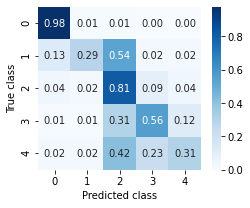

In [ ]:
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(4, 3))
sns.heatmap(cm_norm, square=True, annot=True, fmt='0.2f',
            annot_kws={'fontsize':10}, cmap='Blues', 
            xticklabels=labels, yticklabels=labels);
plt.ylabel('True class');
plt.xlabel('Predicted class');

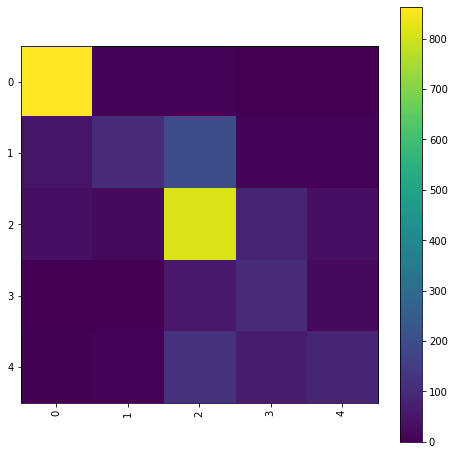

In [ ]:
plt.figure(figsize=(8,8))
cnf_matrix = confusion_matrix(test_generator.classes, y_pred)

plt.imshow(cnf_matrix, interpolation='nearest')
plt.colorbar()
tick_marks = np.arange(len(target_names))
_ = plt.xticks(tick_marks, target_names, rotation=90)
_ = plt.yticks(tick_marks, target_names)
plt.show();

In [ ]:
from sklearn.metrics import roc_curve
y_pred_keras = model.predict(test_generator).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(test_generator.classes, y_pred_keras)

In [ ]:
from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)

In [ ]:
import numpy as np
from scipy import interp
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.metrics import roc_curve, auc

# Plot linewidth.
lw = 2

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(test_generator.classes):
    fpr[i], tpr[i], _ = roc_curve(test_generator[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(1)
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()


# Zoom in view of the upper left corner.
plt.figure(2)
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

In [ ]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
# Zoom in view of the upper left corner.
plt.figure(2)
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.show()